In [105]:
%%capture --no-stderr
%pip install langgraph langchain_core langchain_cummunity
%pip install langchain_google_genai tavily_python markdown2 beautifulsoup4 gtts elevenlabs
!pip install -U langgraph

In [106]:
from langchain_google_genai import ChatGoogleGenerativeAI
import google.generativeai as genai
from google.colab import userdata

GENAI_API_KEY = userdata.get("GOOGLE_API_KEY")

genai.configure(api_key=GENAI_API_KEY)

llm = ChatGoogleGenerativeAI(api_key=GENAI_API_KEY, model="gemini-1.5-pro")
llm.invoke("Hello !")

AIMessage(content='Hello! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-8d1c291c-7bf9-4d2e-b5d1-97a9746d70f4-0', usage_metadata={'input_tokens': 3, 'output_tokens': 10, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

In [107]:
import os
from typing import IO
from io import BytesIO
from elevenlabs import VoiceSettings
from elevenlabs.client import ElevenLabs
from IPython.display import Audio, display

ELEVENLABS_API_KEY = userdata.get("ELEVENLABS_API_KEY")
client = ElevenLabs(
    api_key=ELEVENLABS_API_KEY,
)


def text_to_speech_stream(text: str) -> IO[bytes]:
    # Perform the text-to-speech conversion
    response = client.text_to_speech.convert(
        voice_id="pNInz6obpgDQGcFmaJgB", # Adam pre-made voice
        output_format="mp3_22050_32",
        text=text,
        model_id="eleven_multilingual_v2",
        voice_settings=VoiceSettings(
            stability=0.0,
            similarity_boost=1.0,
            style=0.0,
            use_speaker_boost=True,
        ),
    )

    # Create a BytesIO object to hold the audio data in memory
    audio_stream = BytesIO()

    # Write each chunk of audio data to the stream
    for chunk in response:
        if chunk:
            audio_stream.write(chunk)

    # Reset stream position to the beginning
    audio_stream.seek(0)

    # Return the stream for further use
    return audio_stream



In [108]:
from typing import TypedDict, Literal

class State(TypedDict):
    input: str
    category: str
    news: str
    joke: str
    poem: str

In [109]:
from langchain.prompts.chat import (
    ChatPromptTemplate,
)

def input_user(state: State) -> State:
    state["input"] = input("Enter Message: ")
    return state

def categorize(state: State) -> State:
    prompt = ChatPromptTemplate.from_template("""
        Catagorize the text provided by user{input}. Give response in one word according to following prompt.Catagorize in only "news","poem","joke".
        Example :
        {input} I am Muzzamil.
        general

        {input} Roman vs Cody match is the biggest match of 2023.
        news

        """
    )
    result = prompt.format(input=state["input"])
    # Assuming AIMessage has a 'content' property to access the text
    state["category"] = llm.invoke(result).content.strip()  # Access content and strip
    print(f"Category: {state['category']}")

    return state

def news(state: State) -> State:
   prompt = ChatPromptTemplate.from_template("""
    Rewrite the input provided by user{input} and make it relevant and provide it in anchor style.
    Don't hallucinate anything.

  """)
   result = prompt.format(input=state["input"])
   # Access the 'content' attribute of the AIMessage object before stripping
   state["news"] = llm.invoke(result).content.strip()
   print(state["news"])
   audio_data = text_to_speech_stream(state["news"])
   audio_data1 = audio_data.read()
   display(Audio(audio_data1, rate=22050, autoplay=True))
   return state

def poem(state: State) -> State:
     prompt = ChatPromptTemplate.from_template("""
        Rewrite the input  provide by user {input} and make it accurate .
        Don't hallucinate anything.
        """)
     result = prompt.format(input=state["input"])
     state["poem"] = llm.invoke(result).content.strip()
     print(state["poem"])
     return state

def joke(state: State) -> State:
     prompt = ChatPromptTemplate.from_template("""
            Rewrite prompt provide by user {input} and make it funny .
            Don't hallucinate anything.
            """)
     result = prompt.format(input=state["input"])
     state["joke"] =  llm.invoke(result).content.strip()
     print(state["joke"])
     return state

# Initialize state
initial_state: State = {"input": "", "category": "", "news": "", "joke": "", "poem": ""}
# state = input_user(initial_state)  # Get user input
# state = categorize(state)  # Categorize input

def condition(state: State) -> Literal["generate_news", "generate_poem", "generate_joke"]:
    if state["category"] == "news":
        return "generate_news"
    elif state["category"] == "poem":
        return "generate_poem"
    elif state["category"] == "joke":
        return "generate_joke"

# Print the final output
# print("Category:", state["category"])
# print("Response:", state.get(state["category"], "Category not found or response not generated.")) # add handling if category key is not found

In [110]:
    from langgraph.graph import START, END, StateGraph

builder = StateGraph(State)
# Change the node name to avoid conflict with state keys
builder.add_node("user_input", input_user)
builder.add_node("categorize_input", categorize)
builder.add_node("generate_news", news)
builder.add_node("generate_poem", poem)
builder.add_node("generate_joke", joke)

builder.set_entry_point("user_input")
builder.add_edge("user_input", "categorize_input")
builder.add_conditional_edges("categorize_input", condition)
builder.add_edge("generate_news", END)
builder.add_edge("generate_poem", END)
builder.add_edge("generate_joke", END)


graph = builder.compile()

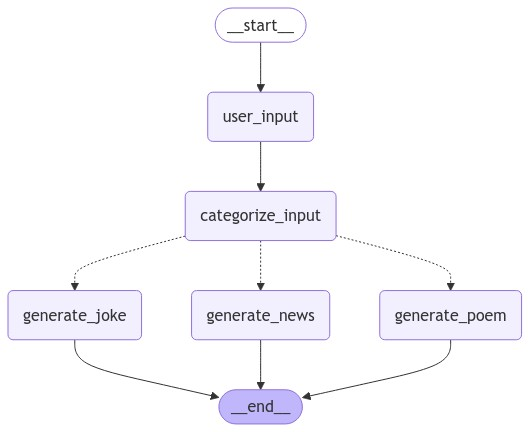

In [111]:
from IPython.display import Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [114]:
app = graph.invoke(initial_state)

Enter Message: OpenAI's new GPT-4 Turbo offers faster, affordable AI capabilities for ChatGPT users, with file uploads, image analysis, and voice chat, now on macOS and expanding to free users with multilingual support.


Category: news
**GPT-4 Turbo: Faster, Cheaper, and More Feature-Rich AI**

*ChatGPT just got a major upgrade.* OpenAI's new GPT-4 Turbo model brings faster and more affordable AI capabilities to users. Key enhancements include file uploads, image analysis, and voice chat.  Initially available on macOS, these features will eventually roll out to free users as well.  Plus, GPT-4 Turbo boasts expanded multilingual support.
